# Мультиклассовая Классификация



Рассмотрим задачу минимизации эмпирического риска
$$
\hat{f} \in \arg\min_{f}\dfrac{1}{N}\sum_{i=1}^N \mathcal{L}(y_i, f(x_i))
$$

Задача *мультиклассовой классификации* определяется множеством допустимых $y \in \mathcal{Y} = \{0, \ldots, K\}$ для $K > 1$. Важно, что конкретный $y_i$ является элементом множеста.

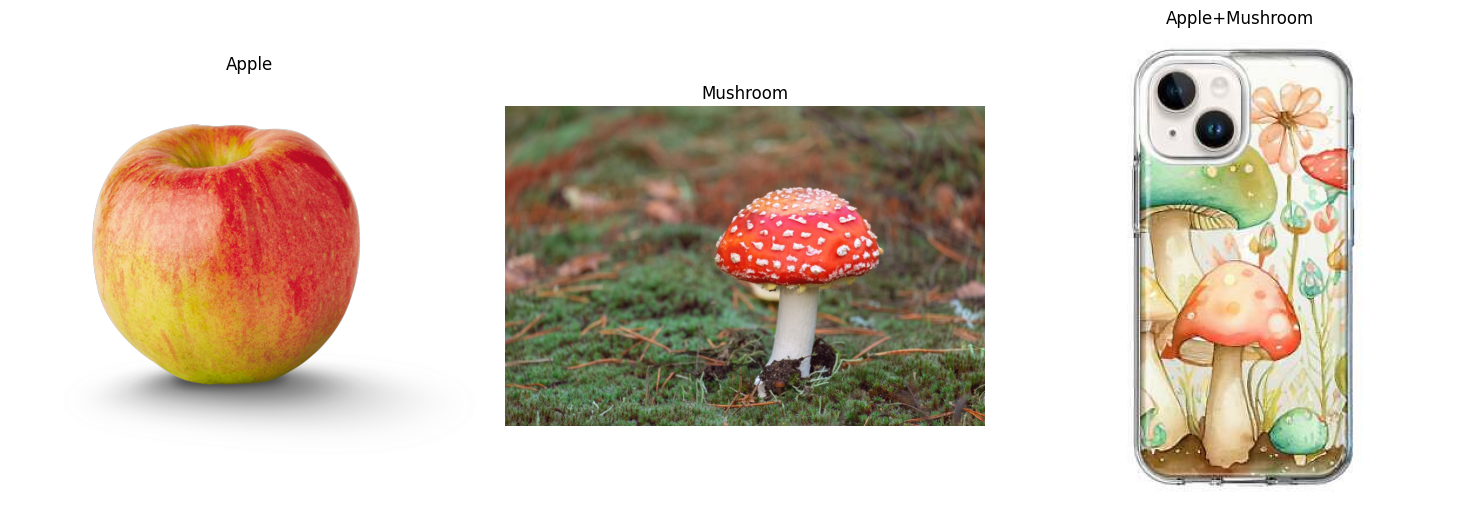

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image1 = mpimg.imread("apple.png")
image2 = mpimg.imread("mushroom.jpg")
image3 = mpimg.imread("apple_mushroom.jpg")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(image1)
axes[0].axis('off')
axes[0].set_title("Apple")

axes[1].imshow(image2)
axes[1].axis('off')
axes[1].set_title("Mushroom")

axes[2].imshow(image3)
axes[2].axis('off')
axes[2].set_title("Apple+Mushroom")

plt.tight_layout()
plt.show()

## Сведение к бинарным задачам

### Один против всех (One-versus-All)

Обучим $K$ линейных классификаторов $b_1(x), b_2(x), \ldots, b_K(x)$ разделять свой класс от всех остальных
$$
b_k(x) = sign(\langle w_k, x\rangle + w_{0k}), \quad y \rightarrow y_k = 2\mathbb{I}[y = k] - 1
$$
Итоговый классификатор будет выдавать класс, соответствующий самому уверенному из бинарных алгоритмов:
$$
f(x) = \arg\max_{k\in\{1,\ldots , K\}} b_k(x)
$$

#### Напоминание: Линейная классификация [(Source)](https://education.yandex.ru/handbook/ml/article/linear-models)

Мы хотим минимизировать число ошибок классификатора, то есть

$$
\dfrac{1}{N} \sum_{i=1}^N \mathbb{I}[y_i \neq b(x)] → \min_{w}
$$
Домножим на $y_i$:
$$
y_i \neq b(x) ⇒ y_i^2 \neq y_i b(x) ⇒ y_i b(x) \neq 1 ⇒ y_i(\langle w, x_i\rangle + w_{0}) < 0
$$
Величина $M_i = y_i(\langle w, x_i\rangle + w_{0})$ называется **отступом (margin)** классификатора.


*   отступ положителен, когда $sign(y_i) = sign(\langle w, x_i\rangle + w_{0})$, то есть класс угадан верно; при этом чем больше отступ, тем больше расстояние от $x_i$ до разделяющей гиперплоскости, то есть «уверенность классификатора»;
*  отступ отрицателен, когда $sign(y_i) \neq sign(\langle w, x_i\rangle + w_{0})$ , то есть класс угадан неверно; при этом чем больше по модулю отступ, тем более сокрушительно ошибается классификатор.

Таким образом, задача линейной классификации
$$
\dfrac{1}{N} \sum_{i=1}^N \mathbb{I}[M_i < 0] → \min_{w} \tag{1}
$$

##### **В чем проблема минимизации функции потерь (1)?**

Функция $\mathbb{I}[M_i < 0]$ является кусочно-постоянной, поэтому её производные равны нулю везде, где существуют. Мы можем мажорировать её какой-нибудь более гладкой функцией


*   Перцептрон: $\max\{0, -M_i\}$
*   Hinge-Loss: $\max\{0, 1 - M_i\}$

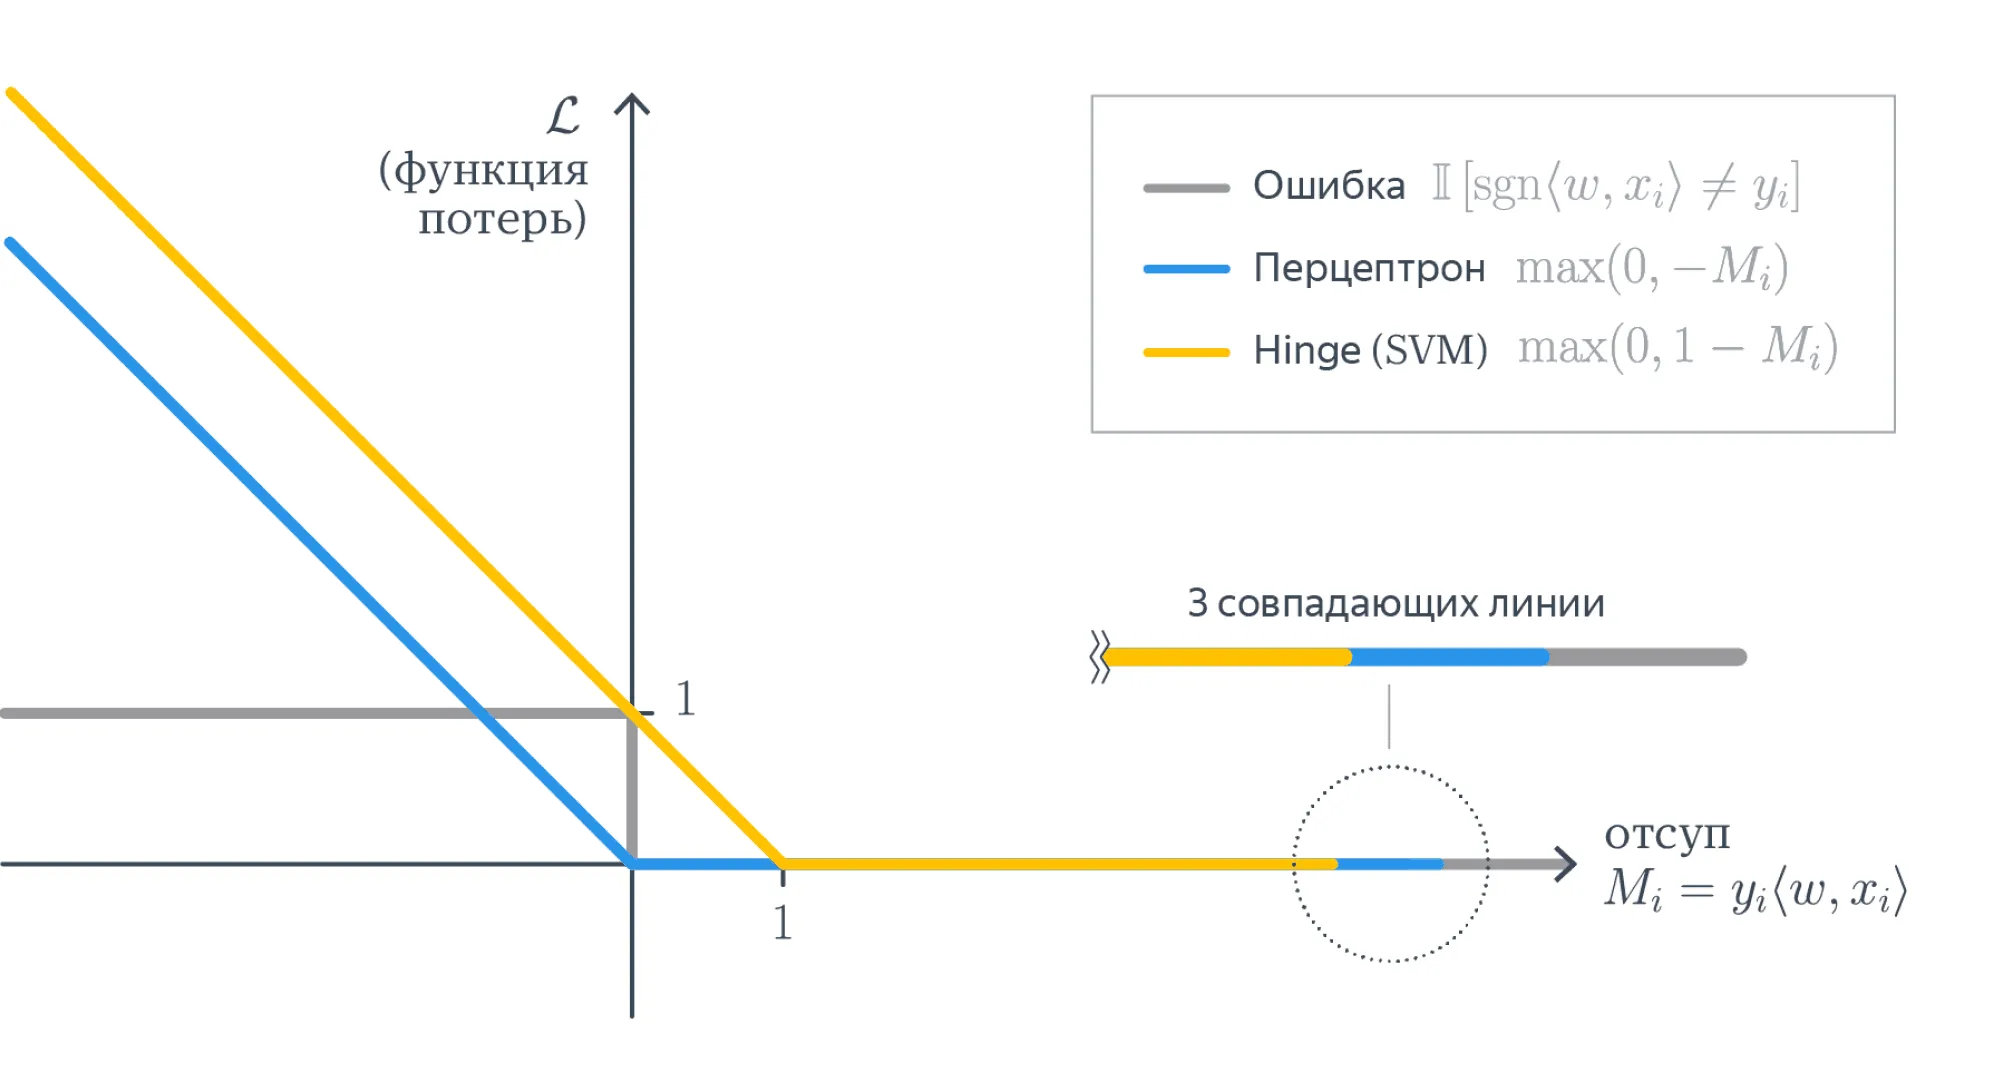

##### **Почему-бы не решать, как задачу регрессии?**

Мы можем попробовать предсказывать числа −1 и 1, минимизируя для этого, например, MSE с последующим взятием знака, но ничего хорошего не получится. Во-первых, регрессия почти не штрафует за ошибки на объектах, которые лежат близко к разделяющей плоскости, но не с той стороны. Во вторых, ошибкой будет считаться предсказание, например, 5 вместо 1, хотя нам-то на самом деле не важно, какой у числа модуль, лишь бы знак был правильным. Если визуализировать такое решение, то проблемы тоже вполне заметны:

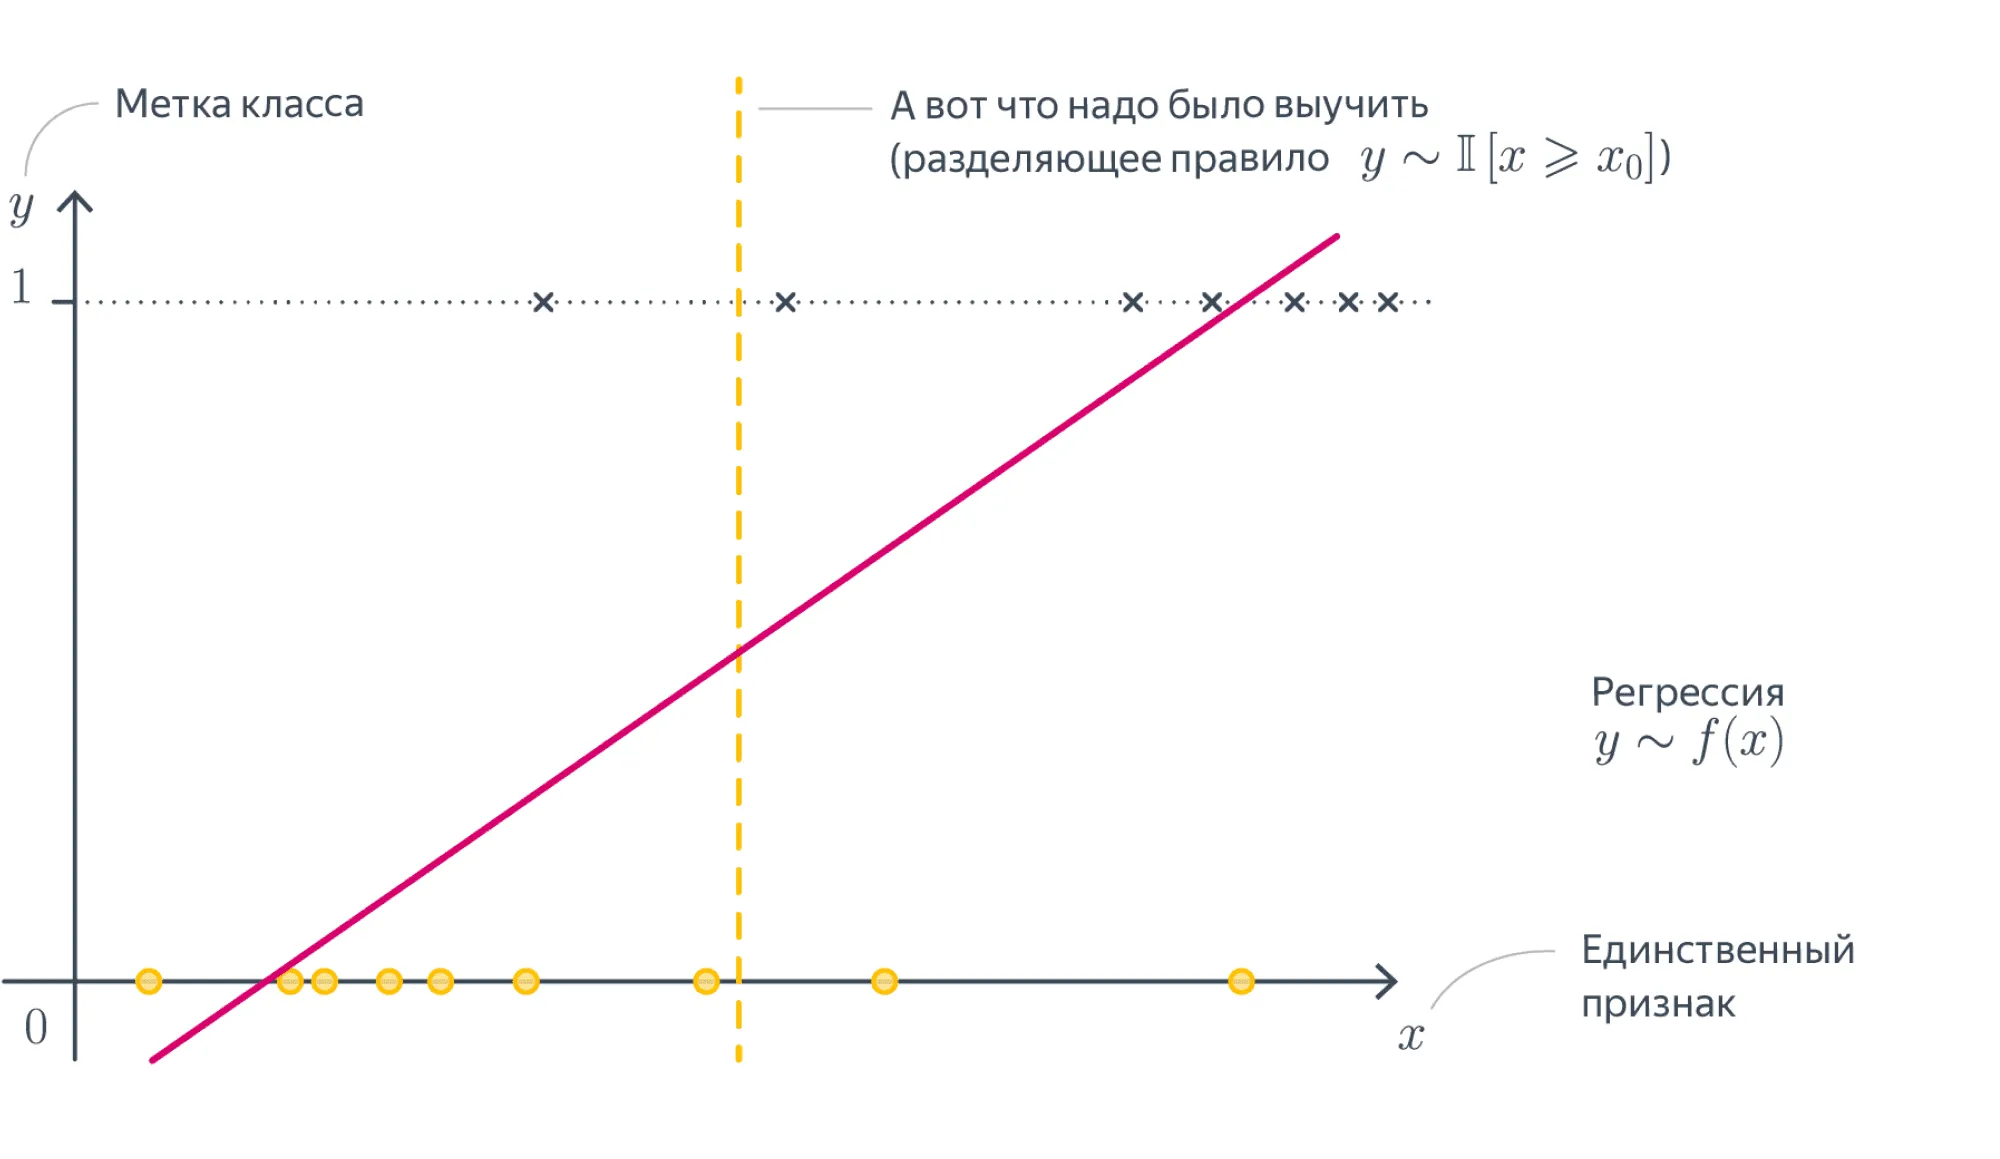

### Импорты

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode
from matplotlib.colors import ListedColormap
from IPython.display import Image
import ast
import pandas as pd
import os

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

#### Имплементация One vs All

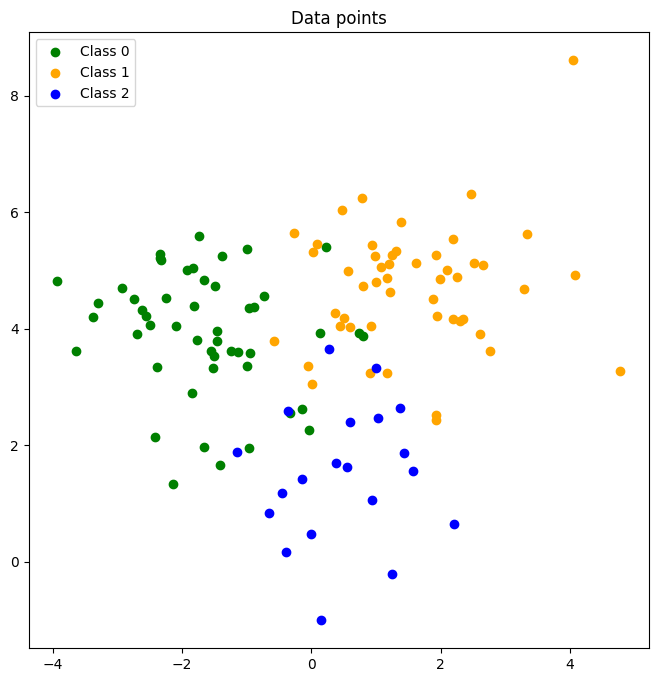

In [ ]:
# Set the random seed for reproducibility
np.random.seed(2)

n_points_cluster1 = 50
n_points_cluster2 = 50
n_points_cluster3 = 20

# Generate clusters using numpy's normal distribution
x1 = np.random.normal(-1.5, 1, size=(n_points_cluster1, 1))
y1 = np.random.normal(4, 1, size=(n_points_cluster1, 1))
labels1 = np.zeros(n_points_cluster1, dtype=int)

x2 = np.random.normal(1.5, 1, size=(n_points_cluster2, 1))
y2 = np.random.normal(4.5, 1, size=(n_points_cluster2, 1))
labels2 = np.ones(n_points_cluster2, dtype=int)

x3 = np.random.normal(0.7, 1, size=(n_points_cluster3, 1))
y3 = np.random.normal(1.5, 1, size=(n_points_cluster3, 1))
labels3 = np.full((n_points_cluster3,), 2, dtype=int)

# Concatenate coordinates and labels
X1 = np.concatenate((x1, y1), axis=1)
X2 = np.concatenate((x2, y2), axis=1)
X3 = np.concatenate((x3, y3), axis=1)

X = np.concatenate((X1, X2, X3), axis=0)
y = np.concatenate((labels1, labels2, labels3), axis=0)

# Plot the data
plt.figure(figsize=(8, 8))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='green', label='Class 0')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='orange', label='Class 1')
plt.scatter(X[y == 2][:, 0], X[y == 2][:, 1], color='blue', label='Class 2')
plt.title("Data points")
plt.legend()
plt.show()

In [ ]:
shuffle_idx = np.random.permutation(X.shape[0])
X = X[shuffle_idx]
y = y[shuffle_idx]

В качестве мажорирующей функции отступа (1) возьмём Hinge-Loss:
$$
\dfrac{1}{N} \sum_{i=1}^N \max\{0, 1 - y_i(\langle w, x_i\rangle + w_0)\} → \min_{w}
$$
Соответствующие градиенты:
$$
\nabla_w = \dfrac{1}{N} \sum_{i=1}^N \begin{cases}
0, & 1 - y_i(\langle w, x_i\rangle + w_0) \leqslant 0 \\
-y_ix_i, & 1 - y_i(\langle w, x_i\rangle + w_0) > 0
\end{cases}
$$
$$
\nabla_{w_0} = \dfrac{1}{N} \sum_{i=1}^N \begin{cases}
0, & 1 - y_i(\langle w, x_i\rangle + w_0) \leqslant 0 \\
-y_i, & 1 - y_i(\langle w, x_i\rangle + w_0) > 0
\end{cases}
$$

Проводим оптимизацию с помощью градиентного спуска
$$
w = w - \eta\nabla_w, \quad w_0 = w_0 - \eta\nabla_{w_0}
$$

In [ ]:
from sklearn.linear_model import SGDClassifier

models = []
for i in range(3):
    # Create binary labels: 1 for class i and -1 for all others
    y_bin = np.where(y == i, 1, -1)
    clf = SGDClassifier(loss='hinge',
                        learning_rate='constant',
                        eta0=0.01,
                        max_iter=1000,
                        tol=1e-3,
                        random_state=42)
    clf.fit(X, y_bin)
    models.append(clf)

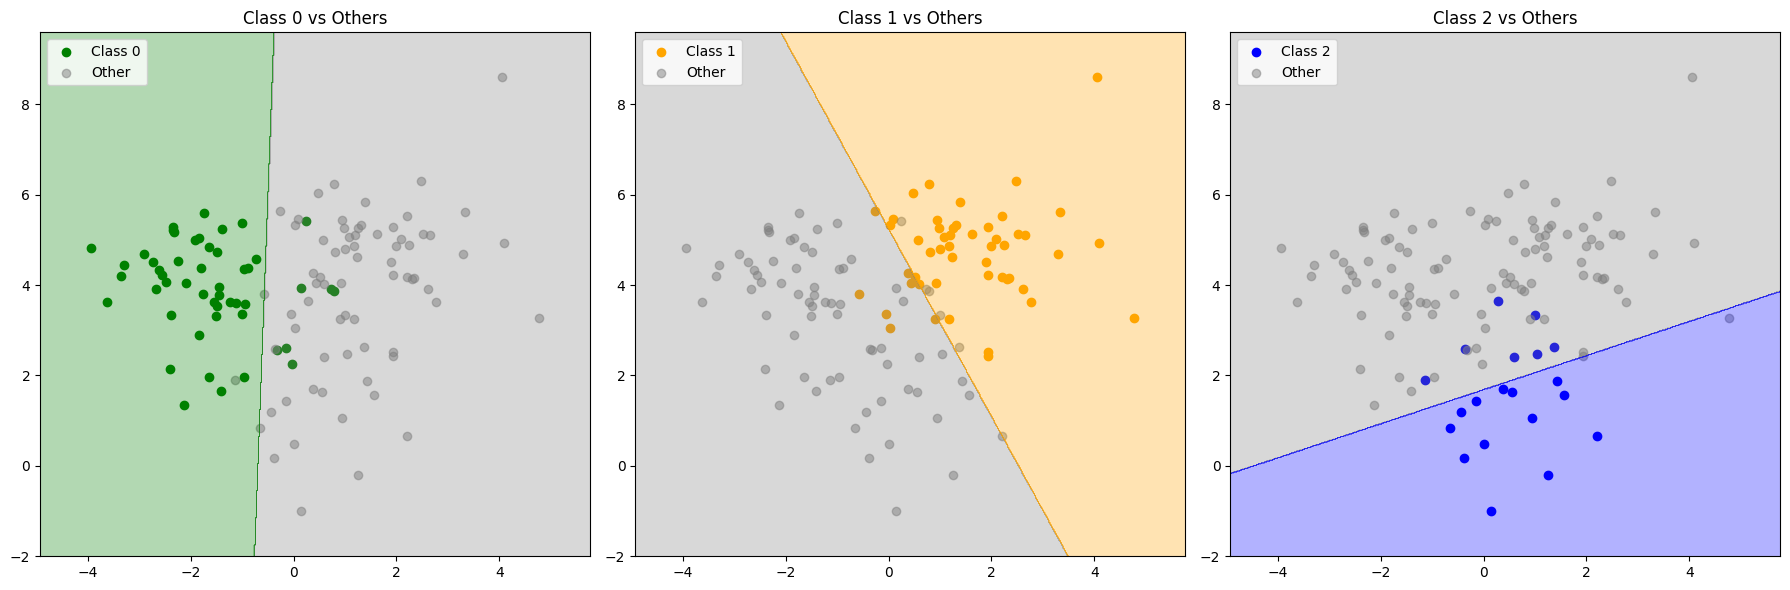

In [ ]:
def plot_binary_bound(X, y, model, mode='ova'):
    assert mode in ['ova', 'ava'], f"plot_binary_bound can work only with (one vs all) or (all vs all) scenarious"
    color_map = {0: "green", 1: "orange", 2: "blue"}
    pairs = [(0, 1), (0, 2), (1, 2)]
    # Make a grid
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    # Create a subplot for each classifier
    fig, axes = plt.subplots(1, len(models), figsize=(18, 6))
    for i, (model, ax, pair) in enumerate(zip(models, axes, pairs)):

        if mode == 'ova':
            cmap = ListedColormap(['gray', color_map[i]])
            ax.scatter(X[y == i][:, 0], X[y == i][:, 1],
                   color=color_map[i], label=f'Class {i}')
            ax.scatter(X[y != i][:, 0], X[y != i][:, 1],
                    color='gray', label='Other', alpha=0.5)
            ax.set_title(f"Class {i} vs Others")
        else:
            cmap = ListedColormap([color_map[pair[0]], color_map[pair[1]]])
            ax.scatter(X[y == pair[0]][:, 0], X[y == pair[0]][:, 1],
                   color=color_map[pair[0]], label=f'Class {pair[0]}')
            ax.scatter(X[y == pair[1]][:, 0], X[y == pair[1]][:, 1],
                    color=color_map[pair[1]], label=f'Class {pair[1]}')
            ax.set_title(f"Class {pair[0]} vs Class {pair[1]}")

        Z = model.predict(grid_points)
        if mode == 'ova':
            # We treat 1 as a true target
            Z = (Z > 0).astype(int)
        else:
            # In ava we manually map labels
            Z = np.where(Z == -1, pair[0], pair[1])
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)
        ax.legend()

    plt.tight_layout()
    plt.show()

plot_binary_bound(X, y, models, mode='ova')

In [ ]:
def ova_ensemble_pred(X, models):
    predictions = [model.decision_function(X) for model in models]
    predictions = np.column_stack(predictions)
    Z = np.argmax(predictions, axis=1)
    return Z

def ava_ensemble_pred(X, models):
    predictions = []
    pairs = [(0, 1), (0, 2), (1, 2)]
    for i, model in enumerate(models):
        pred = model.predict(X)
        # Remap the binary output to the original class labels.
        if i == 0:
            # (-1, 1) --> (0, 1).
            mapped_pred = ((pred + 1) // 2).astype(int)
        elif i == 1:
            # (-1, 1) --> (0, 2)
            mapped_pred = (pred + 1).astype(int)
        elif i == 2:
            # (-1, 1) --> (1, 2)
            mapped_pred = ((pred + 3) // 2).astype(int)
        predictions.append(mapped_pred)
    # Make voting
    predictions = np.column_stack(predictions)
    Z = mode(predictions, axis=1).mode.ravel()
    return Z

def logreg_pred(X, model):
    return model.predict(X)

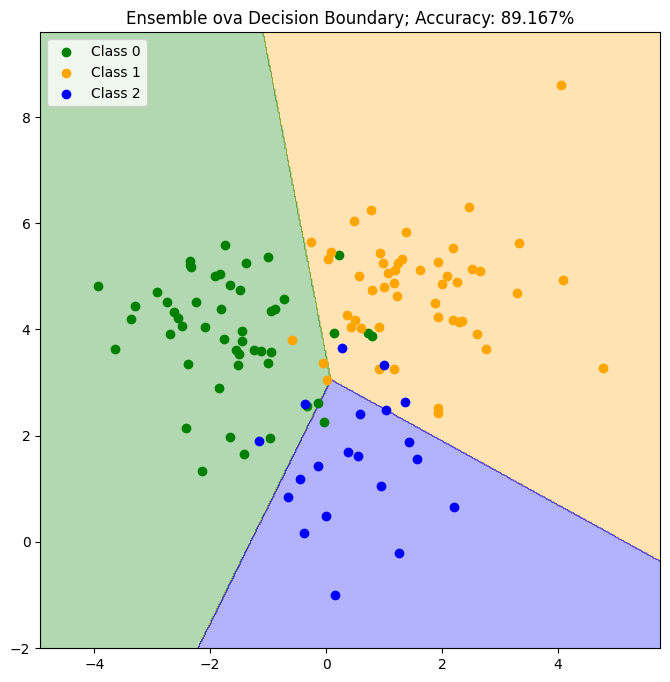

In [ ]:
def plot_ensemble_bound(X, y, models, mode='ova'):
    assert mode in ['ova', 'ava', 'logreg'], f"plot_binary_bound can work only with (one vs all) or (all vs all) or `logreg` scenarious"
    color_map = {0: "green", 1: "orange", 2: "blue"}
    pairs = [(0, 1), (0, 2), (1, 2)]
    # Make a grid
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    # Get ensemble answers
    if mode == 'ova':
        Z = ova_ensemble_pred(grid_points, models)
    elif mode == 'ova':
        Z = ava_ensemble_pred(grid_points, models)
    else:
        Z = logreg_pred(grid_points, models)
    Z = Z.reshape(xx.shape)
    cmap = ListedColormap([color_map[0], color_map[1], color_map[2]])
    # Plot decision boundary
    plt.figure(figsize=(8, 8))
    cmap = ListedColormap(['green', 'orange', 'blue'])
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)
    for i in range(3):
        plt.scatter(X[y == i][:, 0], X[y == i][:, 1],
                    color=color_map[i], label=f'Class {i}')
    # Calculate Train Acc
    if mode == 'ova':
        model_answ = ova_ensemble_pred(X, models)
    elif mode == 'ova':
        model_answ = ava_ensemble_pred(X, models)
    else:
        model_answ = logreg_pred(X, models)
    accuracy = round(np.mean(model_answ == y) * 100, 3)
    # Show plot
    plt.title(f"Ensemble {mode} Decision Boundary; Accuracy: {accuracy}%")
    plt.legend()
    plt.show()

plot_ensemble_bound(X, y, models, mode='ova')

##### **Объясние финальное разделение. Как можно исправить?**



*   каждый из классификаторов $b_1(x), b_2(x), \ldots, b_K(x)$ обучается на своей выборке, и выходы этих классификаторов могут иметь разные масштабы.
*   Нормировать вектора весов, чтобы они выдавали ответы в одной и той же шкале, не всегда может быть разумным решением — так, в случае с SVM веса перестанут являться решением задачи, поскольку нормировка изменит норму весов.



In [ ]:
controversial_ids = [i for i, point in enumerate(X) if point[1] > 2 and point[1] < 2.7 and point[0] > 0 and point[0] < 1.8]
for idx in controversial_ids:
    print(f"Sample Number {idx}: X-coordinates:{X[idx]}, y-label: {y[idx]}")

Sample Number 59: X-coordinates:[1.36422141 2.63274608], y-label: 2
Sample Number 82: X-coordinates:[0.59148318 2.4021794 ], y-label: 2
Sample Number 104: X-coordinates:[1.03048806 2.47550941], y-label: 2


In [ ]:
for idx in controversial_ids:
    model_scores = [round(model.decision_function(X[idx].reshape(1, -1))[0], 3) for model in models]
    print(f"Model scores for idx={idx}: Model 1: {model_scores[1]},  Model 2: {model_scores[2]}")

Model scores for idx=59: Model 1: 0.12,  Model 2: -0.347
Model scores for idx=82: Model 1: -0.857,  Model 2: -0.396
Model scores for idx=104: Model 1: -0.333,  Model 2: -0.322


### Все против всех (all versus all)

Обучим $C^2_K$ линейных классификаторов $a_{ij}(x)$, отделяющих класс $i$ от класса $j,\,\,\,$ $i, j = \overline{1, K}$. В этом случае классификатор настраивается по подвыборке $X_{ij} \subset X$, содержащей только объекты классов $i$ или $j$:
$$
X_{ij} = \left\{(x_n, y_n) \in X \,\bigg|\, \mathbb{I}[y_n = i] = 1\, \text{или}\, \mathbb{I}[y_n = j] = 1\right\}.
$$
Чтобы классифицировать новый объект, подадим его на вход каждого из построенных бинарных классификаторов. Каждый из них проголосует за своей класс; в качестве ответа выберем тот класс, за который наберется больше всего голосов:
$$
a(x) = \arg\max_{k \in \{1, \ldots, K\}}\sum_{i}\sum_{j\neq i}\mathbb{I}[a_{ij}(x) = k]
$$

In [ ]:
num_models = 3  # C^2_3 = 3
pairs = [(0, 1), (0, 2), (1, 2)]
models = []

for pair in pairs:
    mask = (y == pair[0]) | (y == pair[1])
    X_bin = X[mask]
    y_bin = np.where(y[mask] == pair[0], -1, 1)
    shuffle_idx = np.random.permutation(X_bin.shape[0])
    X_bin = X_bin[shuffle_idx]
    y_bin = y_bin[shuffle_idx]

    clf = SGDClassifier(loss='hinge',
                        learning_rate='constant',
                        eta0=0.01,
                        max_iter=1000,
                        tol=1e-3,
                        random_state=42)
    clf.fit(X_bin, y_bin)
    models.append(clf)

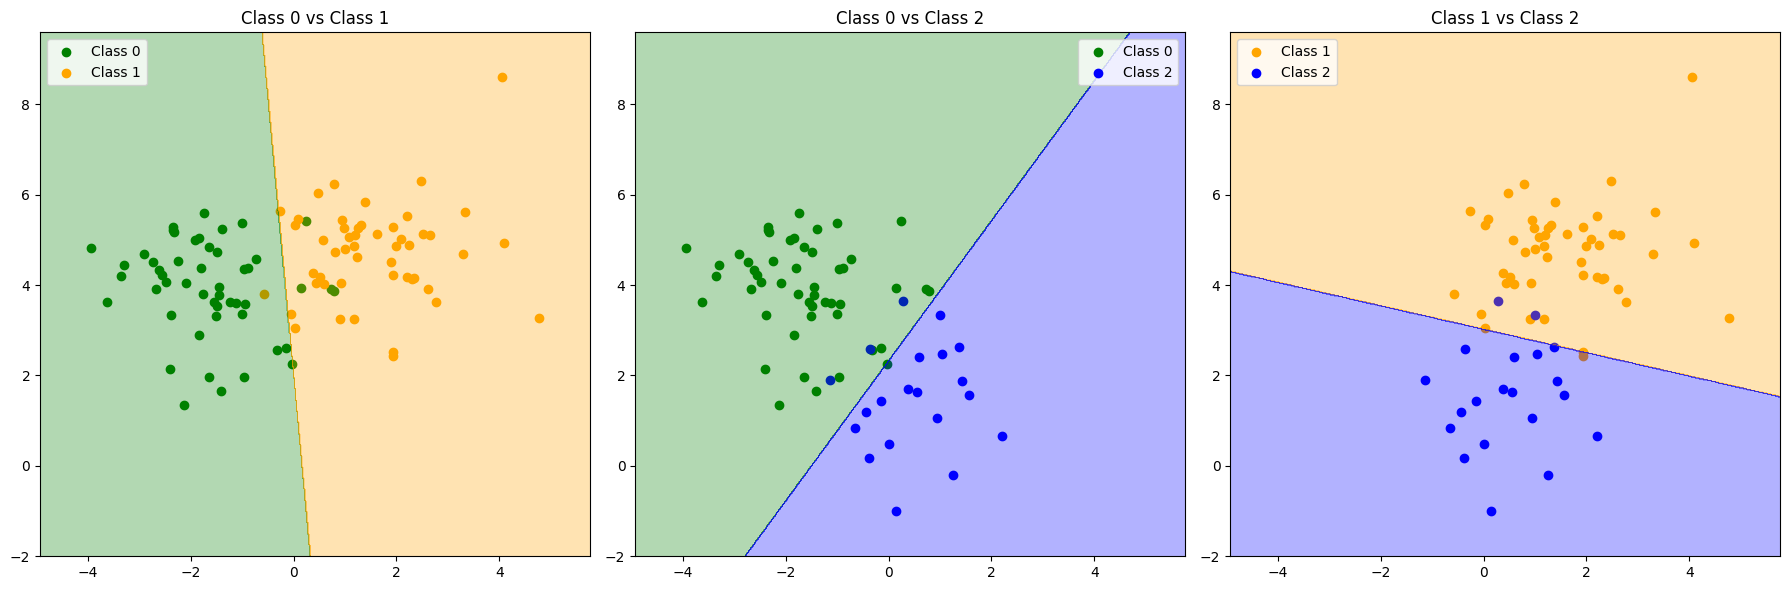

In [ ]:
plot_binary_bound(X, y, models, mode='ava')

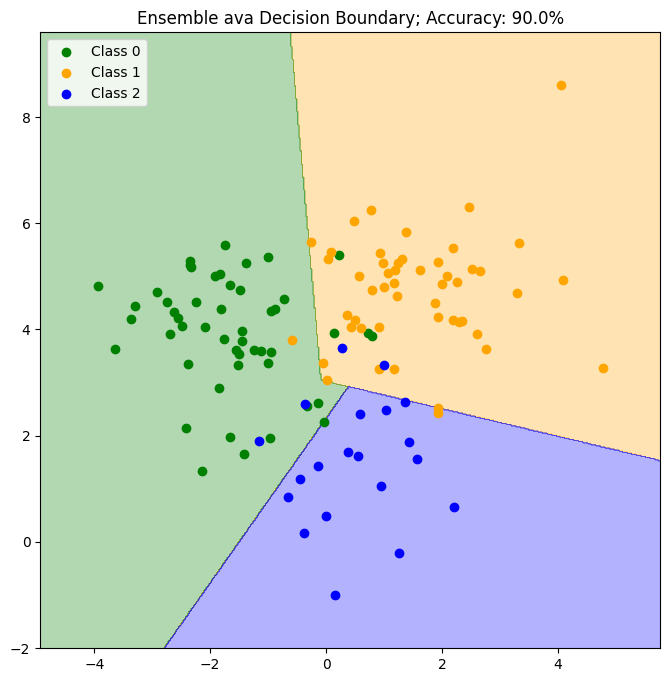

In [ ]:
plot_ensemble_bound(X, y, models, mode='ava')

## Напоминание: бинарная логистическая регрессия [(Source)](https://education.yandex.ru/handbook/ml/article/linear-models)

Идея: давайте свяжем выход $z \in (-\infty, +\infty)$ линейной регрессии с вероятностью выбора положительного класса $p \in (0, 1)$. Для этого представим $z$ в виде **логита**
$$
\langle w, x_i \rangle = \log\left(\dfrac{p}{1-p}\right).
$$
Отсюда можно выразить искомую вероятность:
$$
p = \dfrac{1}{1 + e^{-\langle w, x_i \rangle}}.
$$
Функция в правой части называется **сигмоидой**
$$
\sigma(z) = \dfrac{1}{1 + e^{-z}}
$$
Оптимизация проводится с помощью минимизации логарифма правдоподобия для распределения Бернулли:
$$
\mathcal{L}(w, X, y) = \dfrac{1}{N}\sum_{i=1}^N \log p(y_i | x_i, w) = \dfrac{1}{N}\sum_{i=1}^N (y_i\log(\sigma(\langle w, x_i \rangle)) + (1 - y_i)\log(\sigma(-\langle w, x_i \rangle)))
$$

## Многоклассовая Лог. Регрессия

Бинарную логистическую регрессию можно напрямую обобщить на случай многих классов.
$$
z = \underbrace{X}_{n\times d}\underbrace{W}_{d\times K} + w_0
$$
Связывание вектора $z$ с вектором вероятностей $p$ происходит с помощью SoftMax оператора:
$$
SoftMax(z) = \begin{pmatrix}
\dfrac{\exp{(z_1)}}{\sum_{i=1}^K \exp{(z_i)}}, & \ldots & ,\dfrac{\exp{(z_K)}}{\sum_{i=1}^K \exp{(z_i)}}
\end{pmatrix}^\top
$$
В таком случае оптимизируемая функция потерь
$$
\mathcal{L}(W, X, y) = \dfrac{1}{N}\sum_{i=1}^N \log p(y_i | x_i, W) = \dfrac{1}{N}\sum_{i=1}^N \left[z_{y_i} - \log\left(\sum_{j=1}^K \exp{(z_i)}\right)\right]
$$

#### **Почему использование SoftMax обобщает бинарную лог.-регрессию?**

SoftMax является обобщением сигмоидной функции. Рассмотрим функцию SoftMax для $z = \begin{pmatrix}z_1, & z_2\end{pmatrix}^\top$. Первая компонента вероятности
$$
\dfrac{\exp{(z_1)}}{\exp{(z_1)} + \exp{(z_2)}} = \dfrac{\exp{(z_1 - z_2)}}{1 + \exp{(z_1 - z_2)}} = \sigma(z_1 - z_2).
$$
Аналогично для второй компоненты
$$
\dfrac{\exp{(z_2)}}{\exp{(z_1)} + \exp{(z_2)}} = \sigma(z_2 - z_1)
$$
Обозначая $z := z_1 - z_2$ получаем, что SoftMax описывает 2 компоненты сигмоиды $\sigma(z)$ и $\sigma(1-z)$ как и в бинарном случае.

### Log-Sum-Exp trick

Поскольку $z_i \in (-\infty, +\infty)$, то мы можем столкнуться с численными неустойчивостями при прямом подсчёте SoftMax:

In [ ]:
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z))

z0 = np.array([-3, 0.4])
z1 = np.array([998, 1000])

print(f"Softmax for z0: {softmax(z0)}")
print(f"Softmax for z1: {softmax(z1)}")

Softmax for z0: tensor([0.0323, 0.9677])
Softmax for z1: tensor([nan, nan])


Воспользуемся тем, что в оптимизируемом функционале стоит log-sum-exp и применим следующий "трюк":
$$
\log\left(\sum_{j=1}^K \exp{(z_i)}\right) = \log\left(\sum_{j=1}^K \exp{(z_i - c)}\exp{(c)}\right) = c + \log\left(\sum_{j=1}^K \exp{(z_i - c)}\right).
$$
Таким образом мы убрали экспоненциальную зависимость в линейную. В качестве $c$ логично выбрать $\max_{j}z_j$. Этого же эффекта можно достичь непосредственно при вычислении SoftMax'а

In [ ]:
def SoftMax_Stabilized(z):
    c = np.max(z)
    return np.div(np.exp(z-c), np.sum(np.exp(z-c)))

print(f"Stabilized SoftMax for z0: {SoftMax_Stabilized(z0)}")
print(f"Stabilized SoftMax for z1: {SoftMax_Stabilized(z1)}")

Stabilized SoftMax for z0: tensor([0.0323, 0.9677])
Stabilized SoftMax for z1: tensor([0.1192, 0.8808])


Таким образом, версия, где лоссу подаются сырые логиты вычислительно более стабильная, чем навешивание софт-макса в конец слоя (https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html)

### Классификация лог-регрессии на синтетике

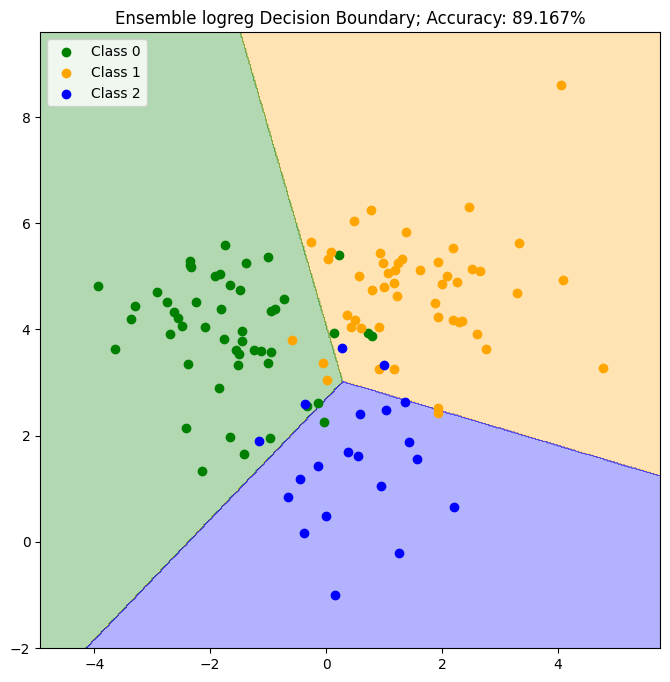

In [ ]:
clf = LogisticRegression()
clf.fit(X, y)
plot_ensemble_bound(X, y, clf, mode='logreg')

### Лог. Регрессия на MNIST

[LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
```
LogisticRegression
(
    penalty='l2', dual=False, tol=0.0001, C=1.0,
    fit_intercept=True, intercept_scaling=1, class_weight=None,
    random_state=None, solver='lbfgs', max_iter=100, multi_class='deprecated',
    verbose=0, warm_start=False, n_jobs=None, l1_ratio=None
)
```


* **penalty:** `{'l1', 'l2', 'elasticnet', None}`, **default=’l2’**
$$
\mathcal{L}(\theta) = -\dfrac{1}{N}\sum_{i=1}^N\log(1 + e^{-y_i\langle\theta, x_i\rangle}) + \dfrac{1}{2C_1}\|\theta\|^2_1 + \dfrac{1}{2C_2}\|\theta\|^2_2 → \min_{θ \in \mathbb{R}^d}
$$
* **dual:** `bool`, **default=False**
$$
G(\alpha) = \min_{θ \in \mathbb{R}^d}\mathcal{L}^\ast(\theta, \alpha) = \sum_{i=1}^N \alpha_i y_i\langle\theta, x_i\rangle - H(\alpha_i) + \dfrac{1}{2C_2}\|\theta\|^2_2, \quad H(\alpha) = -\alpha\log\alpha - (1 - \alpha)\log(1 - \alpha), \alpha \in (0, 1)
$$
$$
\max_{\alpha \in \mathbb{R}^N}G(\alpha)
$$
Заметим, что оптимизация проводится по $\alpha \in \mathbb{R}^N$, т.е. **использование флага dual оправдано, когда количество примеров $N$ меньше, чем количество параметров модели $d$**.
* **solver:** `{‘lbfgs’, ‘liblinear’, ‘newton-cg’, ‘newton-cholesky’, ‘sag’, ‘saga’}`, **default=’lbfgs’**
    * ‘lbfgs’ -- Квази-Ньютоновский алгоритм, $\mathcal{O}(d^2 + Nd)$
    * ‘liblinear’ -- координатный спуск, $\mathcal{O}(Nd)$
    * ‘newton-cg’ -- метод сопряжённых градиентов $\mathcal{O}(Nd)$
    * ‘sag’ -- Стохастический градиентный спуск
    * ‘saga’ -- Стохастический градиентный спуск для негладких регуляризаторов $\ell_1$

[Подробнее](https://tminka.github.io/papers/logreg/minka-logreg.pdf) о сравнении численных оптимизаторов для логистической регрессии

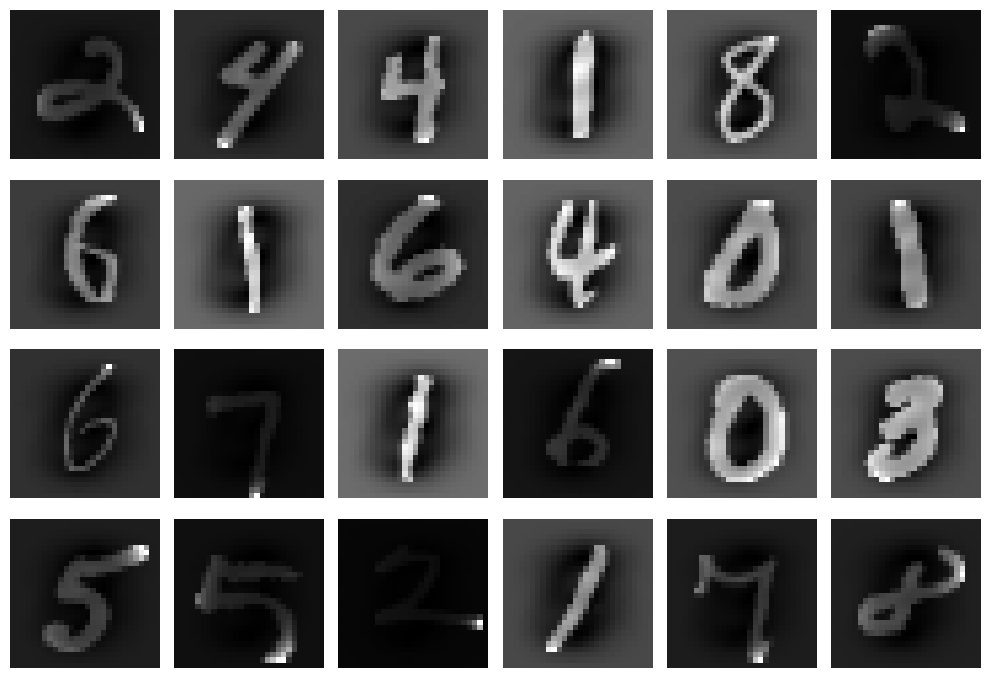

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
from sklearn.model_selection import train_test_split


# Load data from https://www.openml.org/d/554
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

batch = X_test[:24]
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(10, 7))
for i, ax in enumerate(axes.flat):
    ax.imshow(batch[i].reshape(28, 28), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(penalty="l2", solver="sag", tol=0.01)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print("Test score: %.4f" % score)

Test score: 0.9146


## Макро и Микро усреднения

In [ ]:
Image(url='https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/517/images/conf_matrix.png', width=1000)

Формула точности (accuracy) в бинарном случае
$$
Acc = \dfrac{TP + TN}{TP + FN + FP + TN}
$$

##### **Что изменится в случае многих классов?**

In [ ]:
Image(url='https://www.researchgate.net/publication/327148996/figure/fig2/AS:700752393670660@1544083798963/An-illustrative-example-of-the-confusion-matrix-for-a-multi-class-classification-test.png', width=800)

Ничего:)

$$
Acc = \dfrac{TP_1 + TP_2 + \ldots + TP_K}{\sum_{i=1}^K TP_i + \sum_{i\neq j}^K E_{ij}}
$$

#### Несбалансированные выборки

In [ ]:
Image(url='https://cdn.prod.website-files.com/660ef16a9e0687d9cc27474a/662c4267dc614ac9ad29b309_644afc1d1c34d0e4ca2fd06b_class_guide_multi_abc03.png', width=1000)

In [ ]:
Image(url='https://cdn.prod.website-files.com/660ef16a9e0687d9cc27474a/662c4267dc614ac9ad29b312_644afcbeb72fe8ef13eaa139_class_guide_multi_abc05.png', width=1000)

In [ ]:
Image(url='https://www.researchgate.net/profile/Frank-Krueger-2/publication/314116591/figure/fig7/AS:614085901185031@1523420896093/Confusion-matrix-for-multi-class-classification-The-confusion-matrix-of-a-classification.png', width=1000)

$$
Precision_1 = \dfrac{TP_1}{TP_1 + FP_1}, \quad Recall_1 = \dfrac{TP_1}{TP_1 + FN_1}
$$

In [ ]:
Image(url='https://cdn.prod.website-files.com/660ef16a9e0687d9cc27474a/662c4267dc614ac9ad29b2dd_644afe1393e0309cdf690d12_class_guide_multi_abc11.png', width=1000)

In [ ]:
Image(url='https://cdn.prod.website-files.com/660ef16a9e0687d9cc27474a/662c4267dc614ac9ad29b2e9_644afe34b0fb0f18f54d9e2a_class_guide_multi_abc12.png', width=1000)

In [ ]:
Image(url='https://miro.medium.com/v2/resize:fit:4800/format:webp/1*f3EHgDGx0s36zLjfVBrlLA.png', width=1000)

In [ ]:
Image(url='https://miro.medium.com/v2/resize:fit:4800/format:webp/1*fZbppIitaFcpUawKYolWTA.png', width=1000)

In [ ]:
Image(url='https://cdn.prod.website-files.com/660ef16a9e0687d9cc27474a/662c4267dc614ac9ad29b327_644affa21c34d008a8300c4f_class_guide_multi_abc17.png', width=1000)

In [ ]:
Image(url='https://cdn.prod.website-files.com/660ef16a9e0687d9cc27474a/662c4267dc614ac9ad29b305_644afff74301d241c21ba603_class_guide_multi_abc19.png', width=1000)

In [ ]:
Image(url='https://cdn.prod.website-files.com/660ef16a9e0687d9cc27474a/662c4267dc614ac9ad29b31a_644b001227896956fc209ffd_class_guide_multi_abc20.png', width=1000)

In [ ]:
Image(url='https://cdn.prod.website-files.com/660ef16a9e0687d9cc27474a/662c4267dc614ac9ad29b302_644b008f4712a60ca38b2377_class_guide_multi_abc22.png', width=1000)

In [ ]:
Image(url='https://cdn.prod.website-files.com/660ef16a9e0687d9cc27474a/662c4267dc614ac9ad29b321_644b006ad1fd0bdad6008b1e_class_guide_multi_abc23.png', width=1000)

### Метрики Лог. Регрессии на MNIST

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_test, clf.predict(X_test), digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.9538    0.9639    0.9588       942
           1     0.9209    0.9752    0.9473      1087
           2     0.9268    0.8819    0.9038       991
           3     0.8980    0.8756    0.8866      1005
           4     0.9043    0.9378    0.9207       997
           5     0.8875    0.8493    0.8680       929
           6     0.9455    0.9649    0.9551      1025
           7     0.9307    0.9350    0.9328      1077
           8     0.8980    0.8417    0.8689       941
           9     0.8761    0.9066    0.8911      1006

    accuracy                         0.9146     10000
   macro avg     0.9142    0.9132    0.9133     10000
weighted avg     0.9144    0.9146    0.9142     10000



##### **Где микро-усреднение?**

Внимательный зритель обратит внимание, что в примере выше $microPrecision = microRecall = Accuracy$

## Многометная (Multilabel) Классификация

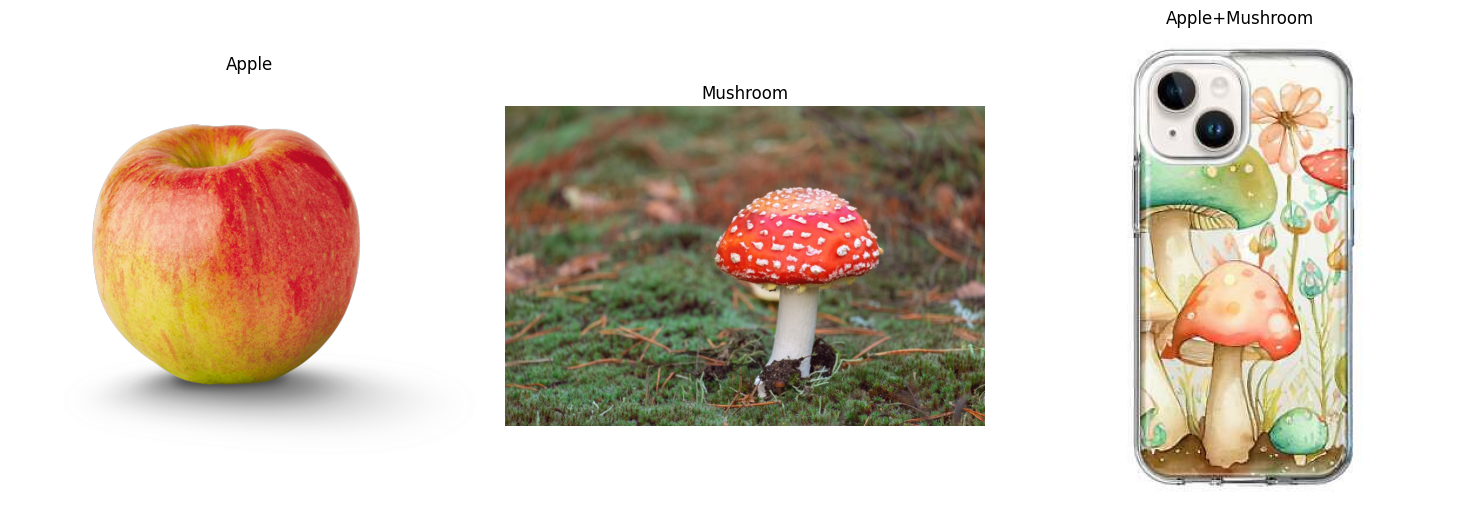

In [ ]:
image1 = mpimg.imread("apple.png")
image2 = mpimg.imread("mushroom.jpg")
image3 = mpimg.imread("apple_mushroom.jpg")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(image1)
axes[0].axis('off')
axes[0].set_title("Apple")

axes[1].imshow(image2)
axes[1].axis('off')
axes[1].set_title("Mushroom")

axes[2].imshow(image3)
axes[2].axis('off')
axes[2].set_title("Apple+Mushroom")

plt.tight_layout()
plt.show()

### Multilabel LogisticRegression

Мы обобщали бинарную логистическую регрессию на случай многоклассовой классификации. Давайте аналогично поступим для многометной:

$$
z = \underbrace{X}_{n\times d}\underbrace{W}_{d\times K} + w_0
$$
В многометном случае $z \notin S_K(1)$, мы трактуем каждую компоненту вектора как принадлежность конкретному классу. Определим соответствующий оператор:
$$
\sigma^K(z) = \begin{pmatrix}
\sigma(z_1), & \ldots & ,\sigma(z_K)
\end{pmatrix}^\top
$$
В таком случае правдоподобие
$$
p(y | x, W) = \prod_{i=1}^N\prod_{j=1}^K p(y_{ij} | x_i, W).
$$
И оптимизируемый функционал
$$
\mathcal{L}(W, X, y) = \dfrac{1}{NK}\sum_{i=1}^N\sum_{j=1}^K \log p(y_{ij} | x_i, W) = \dfrac{1}{NK}\sum_{i=1}^N\sum_{j=1}^K y_{ij}\log p_{ij} + (1 - y_{ij})(1 - \log p_{ij}).
$$
Мы получили знакомую бинарную кросс-энтропию, усреднённую по каждому из классов.

### Метрики многометной классификации

https://mmuratarat.github.io/2020-01-25/multilabel_classification_metrics

## [PTB-XL](https://physionet.org/content/ptb-xl/1.0.3/) example

In [2]:
!unzip ptbxl_features.zip

Streaming output truncated to the last 5000 lines.
  inflating: ptbxl_features/16000_16727_hr.npz  
  inflating: ptbxl_features/16000_16076_hr.npz  
  inflating: ptbxl_features/19000_19780_hr.npz  
  inflating: ptbxl_features/04000_04840_hr.npz  
  inflating: ptbxl_features/00000_00626_hr.npz  
  inflating: ptbxl_features/16000_16490_hr.npz  
  inflating: ptbxl_features/19000_19366_hr.npz  
  inflating: ptbxl_features/19000_19437_hr.npz  
  inflating: ptbxl_features/00000_00177_hr.npz  
  inflating: ptbxl_features/06000_06796_hr.npz  
  inflating: ptbxl_features/09000_09060_hr.npz  
  inflating: ptbxl_features/10000_10520_hr.npz  
  inflating: ptbxl_features/10000_10271_hr.npz  
  inflating: ptbxl_features/09000_09731_hr.npz  
  inflating: ptbxl_features/00000_00491_hr.npz  
  inflating: ptbxl_features/16000_16627_hr.npz  
  inflating: ptbxl_features/12000_12841_hr.npz  
  inflating: ptbxl_features/16000_16176_hr.npz  
  inflating: ptbxl_features/19000_19680_hr.npz  
  inflating: ptbxl

In [3]:
!ls ptbxl_features/ | wc -l

21373


In [6]:
df = pd.read_csv('ptbxl_features/map_file.csv')
df.head(5)

,file_name,ecg_shape,frequency,ecg_duration,mkv,patient_id,doctor_id,device_name,report,scp_codes,...,burst_noise,electrodes_problems,pacemaker,strat_fold,extra_beats,heart_axis,infarction_stadium1,infarction_stadium2,age,target
0,00000_00001_hr.npz,"(12, 5000)",500,10,1,15709,NaN,CS-12 E,sinusrhythmus periphere niederspannung,"['NORM', 'LVOLT', 'SR']",...,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,56.0,[0]
1,00000_00002_hr.npz,"(12, 5000)",500,10,1,13243,NaN,CS-12 E,sinusbradykardie sonst normales ekg,"['NORM', 'SBRAD']",...,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,19.0,[0]
2,00000_00003_hr.npz,"(12, 5000)",500,10,1,20372,NaN,CS-12 E,sinusrhythmus normales ekg,"['NORM', 'SR']",...,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,37.0,[0]
3,00000_00004_hr.npz,"(12, 5000)",500,10,1,17014,NaN,CS-12 E,sinusrhythmus normales ekg,"['NORM', 'SR']",...,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,24.0,[0]
4,00000_00005_hr.npz,"(12, 5000)",500,10,1,17448,NaN,CS-12 E,sinusrhythmus normales ekg,"['NORM', 'SR']",...,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,19.0,[0]


In [16]:
df.columns

Index(['file_name', 'ecg_shape', 'frequency', 'ecg_duration', 'mkv',
       'patient_id', 'doctor_id', 'device_name', 'report', 'scp_codes',
       'report_date', 'original_filename', 'nurse', 'site', 'validated_by',
       'second_opinion', 'initial_autogenerated_report', 'validated_by_human',
       'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
       'pacemaker', 'strat_fold', 'extra_beats', 'heart_axis',
       'infarction_stadium1', 'infarction_stadium2', 'age', 'target'],
      dtype='object')

In [17]:
df['scp_codes']

,scp_codes
0,"['NORM', 'LVOLT', 'SR']"
1,"['NORM', 'SBRAD']"
2,"['NORM', 'SR']"
3,"['NORM', 'SR']"
4,"['NORM', 'SR']"
...,...
21367,"['NORM', 'ABQRS', 'SR']"
21368,"['CRBBB', 'LAFB', '1AVB', 'ABQRS', 'SVARR']"
21369,"['NORM', 'ABQRS', 'VCLVH', 'SR']"
21370,"['IRBBB', 'LAFB', 'SR']"


In [7]:
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.3/162.3 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 35.5 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


[Документация](https://wfdb-python.readthedocs.io/en/latest/index.html) wfdb

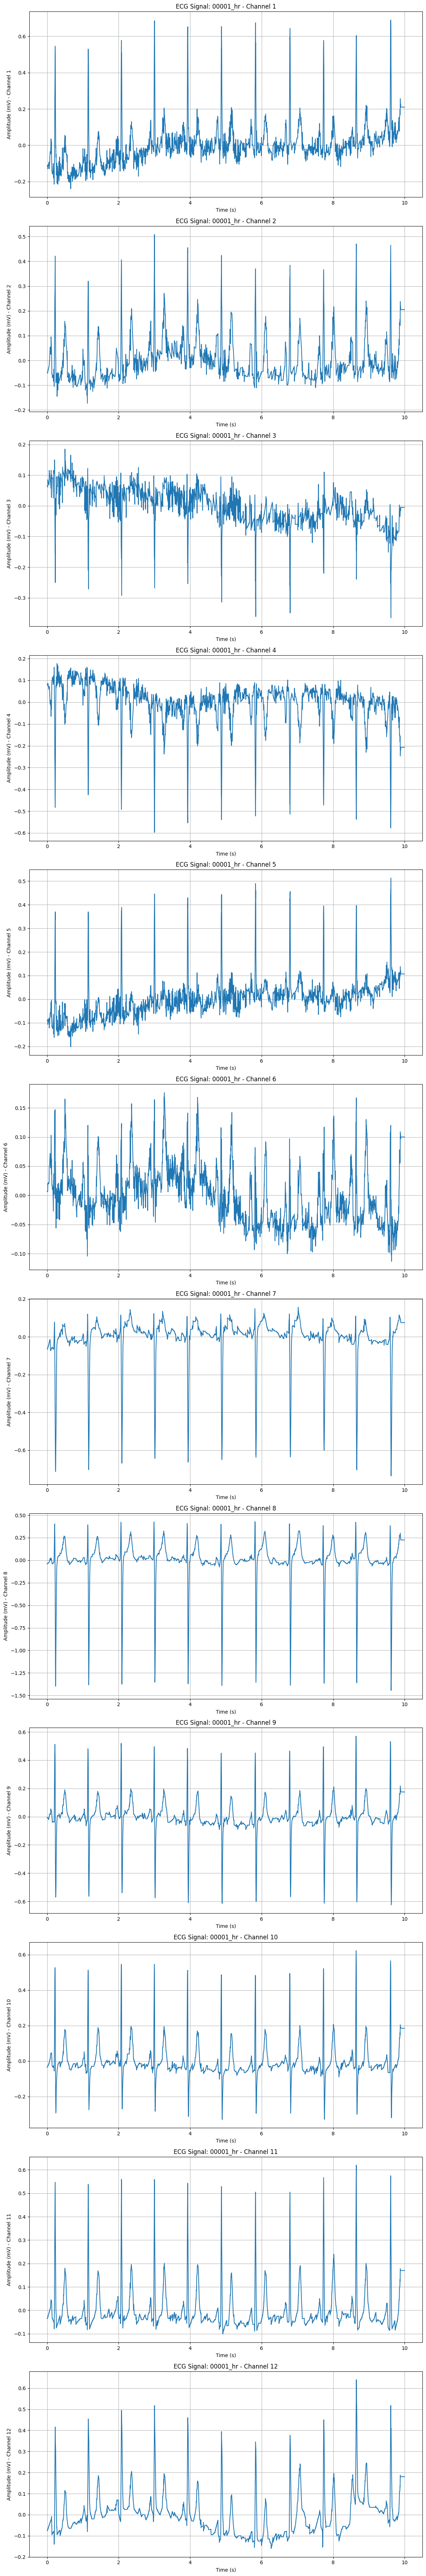

In [14]:
import wfdb

record = wfdb.rdrecord('00001_hr')
fs = record.fs  # Sampling frequency
signal = record.p_signal  # ECG signal in physical units (e.g., mV)
num_channels = signal.shape[1]  # Number of channels

# Create time axis
time = np.arange(len(signal)) / fs

plt.figure(figsize=(12, 6 * num_channels))
for i in range(num_channels):
    plt.subplot(num_channels, 1, i + 1)
    plt.plot(time, signal[:, i])
    plt.xlabel('Time (s)')
    plt.ylabel(f'Amplitude (mV) - Channel {i + 1}')
    plt.title(f'ECG Signal: 00001_hr - Channel {i + 1}')
    plt.grid(True)

plt.tight_layout()
plt.show()

In [15]:
signal.shape

(5000, 12)

1. AFIB -- Atrial FIBrillation
2. PVC -- Premature Ventricular Contractions
3. CRBBB -- Complete Right Bundle Branch Block

In [ ]:
target_codes = ['AFIB', 'PVC', 'CRBBB']
features_dir = 'ptbxl_features'
feature_list = []
labels_list = []

for idx, row in df.iterrows():
    file_name = row['file_name']
    try:
        feature_path = os.path.join(features_dir, file_name)
        feature = np.load(feature_path)['arr_0']
    except:
        print(f'file {feature_path} doesn\'t find in features')
        print(f"Corresponding scps: {row['scp_codes']}")
    feature_list.append(feature)
    scp_codes = ast.literal_eval(row['scp_codes'])
    label = [1 if code in scp_codes else 0 for code in target_codes]
    labels_list.append(label)


X = np.array(feature_list)
y = np.array(labels_list)

print("Features shape:", X.shape)
print("Labels shape:", y.shape)

Features shape: (21372, 512)
Labels shape: (21372, 3)


### Random Split equal weights

In [ ]:
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.pipeline import Pipeline

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=42)
base_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(penalty="l2", solver="sag", tol=0.01, random_state=42))
])

#### MultiOutputClassifier

In [ ]:
multi_output_clf = MultiOutputClassifier(base_pipeline)
multi_output_clf.fit(X_train, y_train)
y_pred_multi = multi_output_clf.predict(X_test)

print("MultiOutputClassifier Performance:")
print(classification_report(y_test, y_pred_multi, zero_division=0.0))

MultiOutputClassifier Performance:
              precision    recall  f1-score   support

           0       0.80      0.79      0.79       127
           1       0.86      0.78      0.82       108
           2       0.76      0.79      0.78        53

   micro avg       0.81      0.78      0.80       288
   macro avg       0.81      0.79      0.80       288
weighted avg       0.81      0.78      0.80       288
 samples avg       0.10      0.09      0.09       288



#### ClassifierChain

In [ ]:
chain_clf = ClassifierChain(base_pipeline, order='random', random_state=42)
chain_clf.fit(X_train, y_train)
y_pred_chain = chain_clf.predict(X_test)

print("ClassifierChain Performance:")
print(classification_report(y_test, y_pred_chain, zero_division=0.0))

ClassifierChain Performance:
              precision    recall  f1-score   support

           0       0.81      0.79      0.80       127
           1       0.86      0.78      0.82       108
           2       0.78      0.79      0.79        53

   micro avg       0.82      0.78      0.80       288
   macro avg       0.81      0.79      0.80       288
weighted avg       0.82      0.78      0.80       288
 samples avg       0.10      0.09      0.09       288



### Random Split balanced weights

In [ ]:
base_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(penalty="l2", solver="sag", tol=0.01, random_state=42, class_weight='balanced'))
])

#### MultiOutputClassifier

In [ ]:
multi_output_clf = MultiOutputClassifier(base_pipeline)
multi_output_clf.fit(X_train, y_train)
y_pred_multi = multi_output_clf.predict(X_test)

print("MultiOutputClassifier Performance:")
print(classification_report(y_test, y_pred_multi, zero_division=0.0))

MultiOutputClassifier Performance:
              precision    recall  f1-score   support

           0       0.56      0.94      0.70       127
           1       0.66      0.97      0.79       108
           2       0.52      0.96      0.67        53

   micro avg       0.58      0.96      0.73       288
   macro avg       0.58      0.96      0.72       288
weighted avg       0.59      0.96      0.73       288
 samples avg       0.10      0.11      0.11       288



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


#### ClassifierChain

In [ ]:
chain_clf = ClassifierChain(base_pipeline, order='random', random_state=42)
chain_clf.fit(X_train, y_train)
y_pred_chain = chain_clf.predict(X_test)

print("ClassifierChain Performance:")
print(classification_report(y_test, y_pred_chain, zero_division=0.0))

ClassifierChain Performance:
              precision    recall  f1-score   support

           0       0.56      0.94      0.70       127
           1       0.67      0.95      0.79       108
           2       0.49      0.96      0.65        53

   micro avg       0.58      0.95      0.72       288
   macro avg       0.57      0.95      0.71       288
weighted avg       0.59      0.95      0.72       288
 samples avg       0.10      0.11      0.11       288



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### Stratified Split balanced weight

In [ ]:
!pip install scikit-multilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 2.2 MB/s eta 0:00:00


In [ ]:
from skmultilearn.model_selection import iterative_train_test_split

X_train, y_train, X_test, y_test = iterative_train_test_split(X, y, test_size = 0.1)
base_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(penalty="l2", solver="sag", tol=0.01, random_state=42, class_weight='balanced'))
])

#### MultiOutputClassifier

In [ ]:
multi_output_clf = MultiOutputClassifier(base_pipeline)
multi_output_clf.fit(X_train, y_train)
y_pred_multi = multi_output_clf.predict(X_test)

print("MultiOutputClassifier Performance:")
print(classification_report(y_test, y_pred_multi, zero_division=0.0))

MultiOutputClassifier Performance:
              precision    recall  f1-score   support

           0       0.65      0.92      0.76       145
           1       0.70      0.97      0.82       111
           2       0.60      0.92      0.73        53

   micro avg       0.66      0.94      0.78       309
   macro avg       0.65      0.94      0.77       309
weighted avg       0.66      0.94      0.78       309
 samples avg       0.11      0.12      0.12       309



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


#### ClassifierChain

In [ ]:
chain_clf = ClassifierChain(base_pipeline, order='random', random_state=42)
chain_clf.fit(X_train, y_train)
y_pred_chain = chain_clf.predict(X_test)

print("ClassifierChain Performance:")
print(classification_report(y_test, y_pred_chain, zero_division=0.0))

ClassifierChain Performance:
              precision    recall  f1-score   support

           0       0.65      0.92      0.76       145
           1       0.70      0.97      0.82       111
           2       0.59      0.96      0.73        53

   micro avg       0.66      0.94      0.78       309
   macro avg       0.65      0.95      0.77       309
weighted avg       0.66      0.94      0.78       309
 samples avg       0.11      0.12      0.12       309



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## Калибровка модели

http://education.yandex.ru/handbook/ml/article/kak-ocenivat-veroyatnosti


## Ссылки

1.   [Лекция](https://github.com/esokolov/ml-course-hse/blob/master/2020-fall/lecture-notes/lecture06-linclass.pdf) Евгения Соколова по многоклассовой классификации
2. [Handbook](https://education.yandex.ru/handbook/ml/article/linear-models) Яндекса по линейным моделям
3. [Визуализации](https://www.evidentlyai.com/classification-metrics/multi-class-metrics) по Макро и Микро усреднениям
4. Набор данных [PTB-XL](https://physionet.org/content/ptb-xl/1.0.3/)
5. [Мерков](https://www.ozon.ru/product/raspoznavanie-obrazov-vvedenie-v-metody-statisticheskogo-obucheniya-merkov-aleksandr-borisovich-255120564/) -- введение в методы стат. обучения (по запросу могу выдать pdf).

